In [1]:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable

/home/ieyuhaoliu/anaconda3/envs/brevitas/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ieyuhaoliu/anaconda3/envs/brevitas/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
data_train = torchvision.datasets.MNIST('./data/', 
                                        train=True, download=True,
                                        transform=torchvision.transforms.Compose
                                        ([
                                            torchvision.transforms.ToTensor(),
                                            #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                            torchvision.transforms.Normalize((0.5,), (0.5,))
                                        ]))
data_test = torchvision.datasets.MNIST('./data/', 
                                       train=False, download=True,
                                       transform=torchvision.transforms.Compose
                                       ([
                                            torchvision.transforms.ToTensor(),
                                            #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                            torchvision.transforms.Normalize((0.5,), (0.5,))
                                       ]))

In [3]:
import torch

batch_size_train = 64
batch_size_test = 1000

data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size=batch_size_train, 
                                                shuffle=True)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size=batch_size_test, 
                                               shuffle=True)

In [4]:
examples = enumerate(data_loader_train)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data[0][0])
example_data[0][0].shape

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

torch.Size([28, 28])

/tmp/ipykernel_5219/1766397098.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


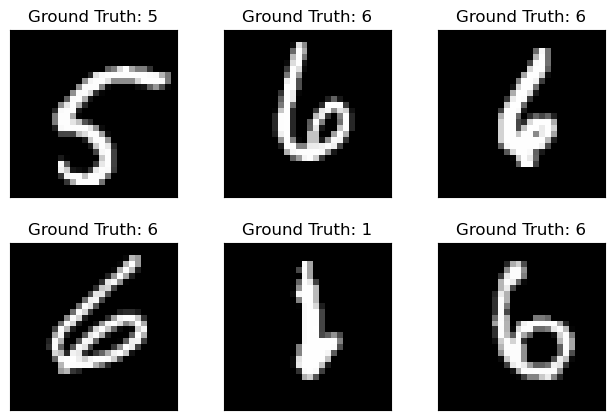

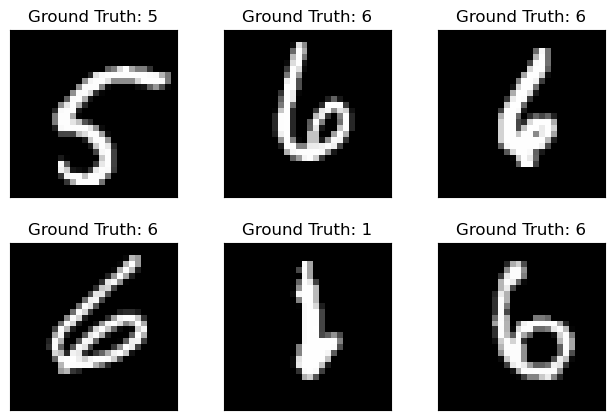

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [6]:
input_size = 1*28*28      
hidden1 = 64      
hidden2 = 64
hidden3 = 64
weight_bit_width = 1
act_bit_width = 1
num_classes = 10  

In [7]:
import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU
import torch.nn as nn
from torch.nn import Module
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType
from brevitas.quant_tensor import QuantTensor
import math
import pwlf
import copy
import matplotlib.pyplot as plt
import numpy as np

# Setting seeds for reproducibility
torch.manual_seed(0)

class TFC_W1A1(Module):
    def __init__(self):
        super(TFC_W1A1, self).__init__()
        
        self.input = qnn.QuantIdentity(
                         quant_type='binary',
                         scaling_impl_type='const',
                         bit_width=1,
                         min_val=-1.0,
                         max_val=1.0, 
                         return_quant_tensor=True
                     )
        
        self.fc1   = qnn.QuantLinear(
                         input_size, 
                         hidden1, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.BINARY,
                         bias=False
                     )
        
        self.bn1   = nn.BatchNorm1d(hidden1)
        self.relu1 = qnn.QuantReLU(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        
        self.fc2   = qnn.QuantLinear(
                         hidden1, 
                         hidden2, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.BINARY,
                         bias=False
                     )
        self.bn2   = nn.BatchNorm1d(hidden2)
        self.relu2 = qnn.QuantReLU(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        
        
        self.fc3   = qnn.QuantLinear(
                         hidden2, 
                         hidden3, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.BINARY,
                         bias=False
                     )
        self.bn3   = nn.BatchNorm1d(hidden3)
        self.relu3 = qnn.QuantReLU(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        
        
        self.out   = qnn.QuantLinear(
                         hidden3, 
                         num_classes, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.BINARY,
                         bias=False
                     )
        
        self.accu_min_1 = 65535.0
        self.accu_max_1 = 0.0
        
        self.bn_min_1 = 65535.0
        self.bn_max_1 = 0.0
        
        self.out_min_1 = 65535.0
        self.out_max_1 = 0.0
        
        self.accu_min_2 = 65535.0
        self.accu_max_2 = 0.0
        
        self.bn_min_2 = 65535.0
        self.bn_max_2 = 0.0
        
        self.out_min_2 = 65535.0
        self.out_max_2 = 0.0
        
        self.accu_min_3 = 65535.0
        self.accu_max_3 = 0.0
        
        self.bn_min_3 = 65535.0
        self.bn_max_3 = 0.0
        
        self.out_min_3 = 65535.0
        self.out_max_3 = 0.0

    def forward(self, x, en):
        
        out = x.reshape(x.shape[0], -1)
        out = self.input(out)
        
        #out = self.relu1(self.bn1(self.fc1(out)))
        out=self.fc1(out)
        if (en==True):
            if (out.max()>self.accu_max_1):
                self.accu_max_1 = out.max()
            if (out.min()<self.accu_min_1):
                self.accu_min_1 = out.min()
        out=self.bn1(out)
        if (en==True):
            if (out.max()>self.bn_max_1):
                self.bn_max_1 = out.max()
            if (out.min()<self.bn_min_1):
                self.bn_min_1 = out.min()
        out=self.relu1(out)
        if (en==True):
            if (out.value.max()>self.out_max_1):
                self.out_max_1 = out.value.max()
            if (out.value.min()<self.out_min_1):
                self.out_min_1 = out.value.min()
                
        #out = self.relu2(self.bn2(self.fc2(out)))
        out=self.fc2(out)
        if (en==True):
            if (out.max()>self.accu_max_2):
                self.accu_max_2 = out.max()
            if (out.min()<self.accu_min_2):
                self.accu_min_2 = out.min()
        out=self.bn2(out)
        if (en==True):
            if (out.max()>self.bn_max_2):
                self.bn_max_2 = out.max()
            if (out.min()<self.bn_min_2):
                self.bn_min_2 = out.min()
        out=self.relu2(out)
        if (en==True):
            if (out.value.max()>self.out_max_2):
                self.out_max_2 = out.value.max()
            if (out.value.min()<self.out_min_2):
                self.out_min_2 = out.value.min()
                
        #out = self.relu3(self.bn3(self.fc3(out)))
        out=self.fc3(out)
        if (en==True):
            if (out.max()>self.accu_max_3):
                self.accu_max_3 = out.max()
            if (out.min()<self.accu_min_3):
                self.accu_min_3 = out.min()
        out=self.bn3(out)
        if (en==True):
            if (out.max()>self.bn_max_3):
                self.bn_max_3 = out.max()
            if (out.min()<self.bn_min_3):
                self.bn_min_3 = out.min()
        out=self.relu3(out)
        if (en==True):
            if (out.value.max()>self.out_max_3):
                self.out_max_3 = out.value.max()
            if (out.value.min()<self.out_min_3):
                self.out_min_3 = out.value.min()
                
        out = self.out(out)
        
        return out
   
model = TFC_W1A1()

In [8]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    
    
    for i, data in enumerate(train_loader, 0):        
        inputs, target = data
        #inputs, target = inputs.cuda(), target.cuda()
        inputs, target = Variable(inputs), Variable(target)
        
        outputs = model(inputs, False)
        _,pred = torch.max(outputs.data,1)
        
        optimizer.zero_grad()
        loss = criterion(outputs,target)
 
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.data.numpy()) 
           
    return losses

In [9]:
import torch
from sklearn.metrics import accuracy_score

def test(model, test_loader, enable=False):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for data in test_loader:
            inputs, target = data
            #inputs, target = inputs.cuda(), target.cuda()
            inputs, target = Variable(inputs),Variable(target)
            output = model(inputs, enable)
            #output = torch.sigmoid(output_orig)  
            _,pred = torch.max(output,1)
            # compare against a threshold of 0.5 to generate 0/1
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

In [10]:
num_epochs = 10
learn_rate = 0.001 

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [11]:
# loss criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, betas=(0.9, 0.999))

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

running_loss = []
running_test_acc = []
t = trange(num_epochs, desc="Training loss", leave=True)

for epoch in t:
        loss_epoch = train(model, data_loader_train, optimizer, criterion)
        test_acc = test(model, data_loader_test)
        t.set_description("Training loss = %f test accuracy = %f" % (np.mean(loss_epoch), test_acc))
        t.refresh() # to show immediately the update           
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)

Training loss = 0.258525 test accuracy = 0.922900: 100%|█| 10/10 [04:43<00:00, 2


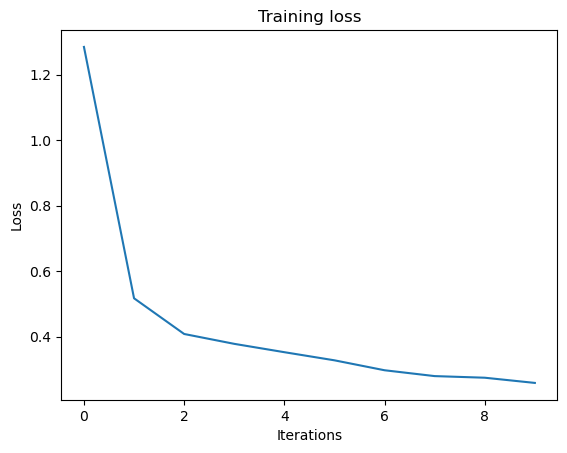

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

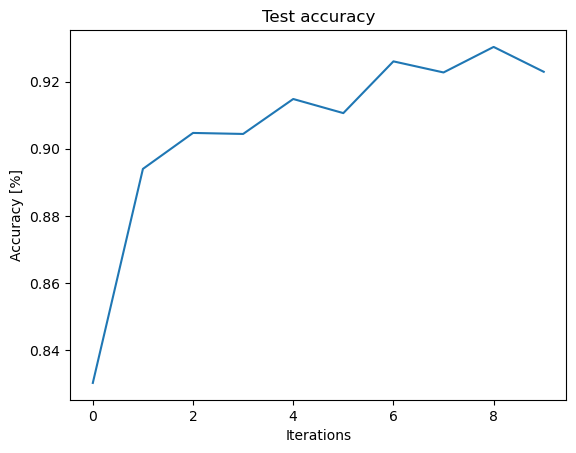

In [14]:
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

In [15]:
test(model, data_loader_test, True)

0.9229

In [18]:
test_1_in = torch.from_numpy(np.ones((1000,64)).astype('f'))
test_1_out = model.relu1(model.bn1(test_1_in))
scale_1 = test_1_out.scale.cpu().detach().numpy()
zero_point_1 = test_1_out.zero_point.cpu().detach().numpy()

test_2_in = torch.from_numpy(np.ones((1000,64)).astype('f'))
test_2_out = model.relu2(model.bn2(test_2_in))
scale_2 = test_2_out.scale.cpu().detach().numpy()
zero_point_2 = test_2_out.zero_point.cpu().detach().numpy()

test_3_in = torch.from_numpy(np.ones((1000,64)).astype('f'))
test_3_out = model.relu3(model.bn3(test_3_in))
scale_3 = test_3_out.scale.cpu().detach().numpy()
zero_point_3 = test_3_out.zero_point.cpu().detach().numpy()

In [20]:
print("Layer 1:\n")
print(" Accumulator Output Range: [", model.accu_min_1, ", ", model.accu_max_1, "]\n") 
print(" BN Output Range: [", model.bn_min_1, ", ", model.bn_max_1, "]\n") 
print(" Multi-Threshold Output Range: [", model.out_min_1/scale_1+zero_point_1, ", ", model.out_max_1/scale_1+zero_point_1, "]\n") 
print(" A2B Scale factor: ", "%.4f" %((model.bn_max_1-model.bn_min_1)/(model.accu_max_1-model.accu_min_1))) 
print(" B2M Scale factor: ", "%.4f" %(((model.out_max_1-model.out_min_1)/scale_1+zero_point_1)/(model.bn_max_1-model.bn_min_1))) 
print(" A2M Scale factor: ", "%.4f" %(((model.out_max_1-model.out_min_1)/scale_1+zero_point_1)/(model.accu_max_1-model.accu_min_1)), "\n")

print("Layer 2:\n") 
print(" Accumulator Output Range: [", model.accu_min_2, ", ", model.accu_max_2, "]\n") 
print(" BN Output Range: [", model.bn_min_2, ", ", model.bn_max_2, "]\n") 
print(" Multi-Threshold Output Range: [", model.out_min_2/scale_2+zero_point_2, ", ", model.out_max_2/scale_2+zero_point_2, "]\n") 
print(" A2B Scale factor: ", "%.4f" %((model.bn_max_2-model.bn_min_2)/(model.accu_max_2-model.accu_min_2))) 
print(" B2M Scale factor: ", "%.4f" %(((model.out_max_2-model.out_min_2)/scale_2+zero_point_2)/(model.bn_max_2-model.bn_min_2))) 
print(" A2M Scale factor: ", "%.4f" %(((model.out_max_2-model.out_min_2)/scale_2+zero_point_2)/(model.accu_max_2-model.accu_min_2)), "\n")

print("Layer 3:\n") 
print(" Accumulator Output Range: [", model.accu_min_3, ", ", model.accu_max_3, "]\n") 
print(" BN Output Range: [", model.bn_min_3, ", ", model.bn_max_3, "]\n") 
print(" Multi-Threshold Output Range: [", model.out_min_3/scale_3+zero_point_3, ", ", model.out_max_3/scale_3+zero_point_3, "]\n") 
print(" A2B Scale factor: ", "%.4f" %((model.bn_max_3-model.bn_min_3)/(model.accu_max_3-model.accu_min_3))) 
print(" B2M Scale factor: ", "%.4f" %(((model.out_max_3-model.out_min_3)/scale_3+zero_point_3)/(model.bn_max_3-model.bn_min_3))) 
print(" A2M Scale factor: ", "%.4f" %(((model.out_max_3-model.out_min_3)/scale_3+zero_point_3)/(model.accu_max_3-model.accu_min_3)), "\n")

Layer 1:

 Accumulator Output Range: [ tensor(-393.5452) ,  tensor(469.9043) ]

 BN Output Range: [ tensor(-7.1732) ,  tensor(6.0491) ]

 Multi-Threshold Output Range: [ tensor(0.) ,  tensor(1.) ]

 A2B Scale factor:  0.0153
 B2M Scale factor:  0.0785
 A2M Scale factor:  0.0012 

Layer 2:

 Accumulator Output Range: [ tensor(-26.5843) ,  tensor(25.4766) ]

 BN Output Range: [ tensor(-4.8631) ,  tensor(6.0278) ]

 Multi-Threshold Output Range: [ tensor(0.) ,  tensor(1.) ]

 A2B Scale factor:  0.2092
 B2M Scale factor:  0.1357
 A2M Scale factor:  0.0192 

Layer 3:

 Accumulator Output Range: [ tensor(-33.4558) ,  tensor(30.9776) ]

 BN Output Range: [ tensor(-4.9878) ,  tensor(6.1816) ]

 Multi-Threshold Output Range: [ tensor(0.) ,  tensor(1.) ]

 A2B Scale factor:  0.1733
 B2M Scale factor:  0.1335
 A2M Scale factor:  0.0155 

